# Question 2: Classification
## Machine Learning Foundations with Python 
### 90-803 - Spring 2024
### Sprint Team #17
### Name:  Jewel Yoko Kentilitisca, Hannah Ngyugen, Quintessa Guegerich


### Can we predict the impact of rising temperatures on changes in property prices in areas designated as "climate ready"?
Reference for "climate ready" states: (https://www.architecturaldigest.com/reviews/solar/most-climate-resilient-cities)

   Target variable: The target variable for this classification problem is the direction of the impact of rising temperatures on property prices in a given area. It is represented as a categorical variable with three levels:

    (a) 3 - Positive impact: Rising temperatures lead to a significant increase in property prices 
    (b) 2 - Medium impact: Rising temperatures lead to a moderate increase in property prices
    (c) 1 - Negative impact: Rising temperatures lead to a decrease in property prices


### Ideas 
   (a) Generate a heatmap to visualize the correlation matrix between temperature anomalies and other variables, including housing price changes. 

In [41]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

### Preprocessing the Data

In [2]:
#Dictionary for state codes for us to be able to merge another dataset for longitude and latitude
state_codes = {
    'AL': '01',
    'AK': '02',
    'AZ': '04',
    'AR': '05',
    'CA': '06',
    'CO': '08',
    'CT': '09',
    'DE': '10',
    'FL': '12',
    'GA': '13',
    'HI': '15',
    'ID': '16',
    'IL': '17',
    'IN': '18',
    'IA': '19',
    'KS': '20',
    'KY': '21',
    'LA': '22',
    'ME': '23',
    'MD': '24',
    'MA': '25',
    'MI': '26',
    'MN': '27',
    'MS': '28',
    'MO': '29',
    'MT': '30',
    'NE': '31',
    'NV': '32',
    'NH': '33',
    'NJ': '34',
    'NM': '35',
    'NY': '36',
    'NC': '37',
    'ND': '38',
    'OH': '39',
    'OK': '40',
    'OR': '41',
    'PA': '42',
    'RI': '44',
    'SC': '45',
    'SD': '46',
    'TN': '47',
    'TX': '48',
    'UT': '49',
    'VT': '50',
    'VA': '51',
    'WA': '53',
    'WV': '54',
    'WI': '55',
    'WY': '56'
}


In [3]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()
merged_data['StateFP'] = merged_data['StateAbbrv'].map(state_codes)
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on=['RegionName', 'StateFP'], right_on=['NAMELSAD', 'STATEFP'])

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Filtering for states we wanna deep dive in
filtered_states = merged_data.sample(n=100000, random_state=42)


### Figuring out how to make this into a classification problem

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies [did not go with this option]
2. Look at the ratio changes between purchase price, bottom tier average home value estimate, and top tier average home value estimate, grouping by month/year.
3. Include temperature anomaly data into one combined value reflecting the impact on housing prices, trying to calculate by putting weights?

    -Normalizing the Temperature Anomaly Data: Ensure that the temperature anomaly data is on a similar scale as the housing price data. This might involve scaling or normalization.

    -Define Weights: Assign weights to the housing price change and temperature anomaly change based on their relative importance in influencing housing prices. These weights can be subjective.

    -Calculate Combined Impact: Multiply the percentage change in housing prices and the normalized temperature anomaly data by their respective weights, and then add them together to get a combined impact value.

### Intention: Look if positive values may indicate that higher temperature anomalies are associated with a higher likelihood of a certain class (higher percentage change in housing prices, both for bottom tier and top tier), while negative values may indicate the opposite.

### The idea was to make a ratio change/ percentage change of each year of bottom tier home value prices, top tier home value prices, and purchase price 

In [4]:
# Group the data by 'County Name' and calculate the percentage change for each group
filtered_states['Pct_Change_Bottom_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Bottom-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Pct_Change_Top_Tier'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Top-Tier Average Home Value Estimate'].pct_change()*100
filtered_states['Pct_Change'] = filtered_states.groupby(['RegionName', 'State', 'Month', 'Term to Maturity'])['Purchase Price ($thou)'].pct_change()*100

#Creating a new column for the ratio change of 'Bottom_Tier', 'Top_Tier', and 'Pct_Change'
filtered_states['Ratio_Change_Bottom_Tier'] = filtered_states['Pct_Change_Bottom_Tier'] / filtered_states['Anomaly (1901-2000 base period)']
filtered_states['Ratio_Change_Top_Tier'] = filtered_states['Pct_Change_Top_Tier'] / filtered_states['Anomaly (1901-2000 base period)']
filtered_states['Ratio_Change_Purchase_Price_Tier'] = filtered_states['Pct_Change'] / filtered_states['Anomaly (1901-2000 base period)']

filtered_states.head()


,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
222950,31550,2001-08-31,2001,8,Columbia County,NY,64686.491365,224005.760248,72.0,3.7,...,35071400.0,42.247696,-73.626717,"POLYGON ((-73.38220 42.42944, -73.38271 42.428...",NaN,NaN,NaN,NaN,NaN,NaN
348656,585798,2019-01-31,2019,1,Talbot County,GA,39151.256050,203723.960071,47.1,1.9,...,8766848.0,32.704603,-84.530029,"POLYGON ((-84.70054 32.84464, -84.69478 32.844...",NaN,NaN,NaN,NaN,NaN,NaN
483655,429255,2015-04-30,2015,4,Shawano County,WI,63303.534034,199619.561599,44.5,2.6,...,41883059.0,44.789641,-88.755813,"POLYGON ((-88.73619 44.85638, -88.72764 44.856...",NaN,NaN,NaN,NaN,NaN,NaN
331244,73158,2003-08-31,2003,8,Long County,GA,73068.250206,220987.343181,81.2,0.5,...,8862019.0,31.749563,-81.742870,"POLYGON ((-81.98148 31.80006, -81.98090 31.800...",NaN,NaN,NaN,NaN,NaN,NaN
206363,569865,2018-09-30,2018,9,Creek County,OK,69590.126678,239924.970892,74.4,1.0,...,50817257.0,35.907398,-96.380177,"POLYGON ((-96.28149 35.63882, -96.28200 35.638...",NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning the Data
(a) Since there we did a percentage change on Purchase Price, Bottom Tier Average Home Value Estimate and Top Tier Average Home Value Estimate, there will be Nans on the first year (all of 2000). THe number of null values is consistent with the number of counties * 2 (because we have 2 values per date for 15 year and 30 year loan).

In [5]:
#Looking at null values since we did a percentange change and will most likely have Nans
pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

,Number missing values,Percentage of missing values
Unnamed: 0,0,0.000
Date,0,0.000
Year,0,0.000
Month,0,0.000
RegionName,0,0.000
State,0,0.000
Bottom-Tier Average Home Value Estimate,0,0.000
Top-Tier Average Home Value Estimate,0,0.000
Value,0,0.000
Anomaly (1901-2000 base period),0,0.000


(b) Dropping Nans

In [6]:
columns_to_drop_nans = ['Pct_Change_Bottom_Tier', 'Pct_Change_Top_Tier', 'Pct_Change', 'Ratio_Change_Bottom_Tier', 'Ratio_Change_Top_Tier', 'Ratio_Change_Purchase_Price_Tier']
filtered_states.dropna(subset=columns_to_drop_nans, inplace=True)

In [7]:
#Checking Again
#Looking at null values since we did a percentange change and will most likely have Nans
pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

,Number missing values,Percentage of missing values
Unnamed: 0,0,0.0
Date,0,0.0
Year,0,0.0
Month,0,0.0
RegionName,0,0.0
State,0,0.0
Bottom-Tier Average Home Value Estimate,0,0.0
Top-Tier Average Home Value Estimate,0,0.0
Value,0,0.0
Anomaly (1901-2000 base period),0,0.0


#### Before dropping any columns, lets look at the spread 

In [8]:
#Looking at who has the highest ratio change for purchase price
top_ratio_changes = filtered_states.sort_values(by='Ratio_Change_Top_Tier', ascending=False)
top_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
311887,94753,2004-08-31,2004,8,Somerset County,MD,50404.222839,203963.299259,75.2,-0.0,...,752652883.0,38.074450,-75.853323,"POLYGON ((-75.87226 38.22220, -75.87103 38.224...",-9.960404,-4.257117,-3.582090,inf,inf,inf
373841,326767,2012-09-30,2012,9,Iredell County,NC,91477.794493,321578.650194,69.4,0.0,...,59508634.0,35.806250,-80.874524,"POLYGON ((-80.83351 35.50965, -80.83365 35.509...",0.169332,2.276464,14.666667,inf,inf,inf
286654,169936,2007-11-30,2007,11,Scotland County,NC,33493.894824,152390.561649,51.6,0.0,...,3842049.0,34.840023,-79.477337,"POLYGON ((-79.58562 34.95475, -79.58553 34.954...",11.194745,7.753831,13.213448,inf,inf,inf
147461,108503,2005-04-30,2005,4,Blount County,TN,79425.652863,227558.087860,57.1,-0.0,...,20158689.0,35.688185,-83.922973,"POLYGON ((-83.92084 35.47385, -83.92098 35.473...",-17.231657,-14.651929,-14.535769,inf,inf,inf
250012,438948,2015-07-31,2015,7,Carter County,OK,37624.008933,190762.590174,83.3,0.0,...,29733323.0,34.251848,-97.287927,"POLYGON ((-97.56256 34.11482, -97.56239 34.115...",8.895156,4.572954,-1.219950,inf,inf,-inf


In [9]:
bottom_ratio_changes = filtered_states.sort_values(by='Ratio_Change_Bottom_Tier', ascending=False)
bottom_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
221979,570039,2018-09-30,2018,9,Walla Walla County,WA,170020.397121,387544.920308,62.5,0.0,...,74932288.0,46.254606,-118.480370,"POLYGON ((-118.40382 46.00077, -118.40506 46.0...",53.427858,35.987773,15.753938,inf,inf,inf
23795,134429,2006-06-30,2006,6,Gwinnett County,GA,128820.017126,322174.459822,75.4,0.0,...,15624550.0,33.958756,-84.025735,"POLYGON ((-84.11389 34.08440, -84.11382 34.085...",18.578117,16.641484,-6.910876,inf,inf,-inf
278035,344385,2013-02-28,2013,2,Isle of Wight County,VA,101331.870205,344421.615455,41.0,0.0,...,122099188.0,36.901418,-76.707569,"POLYGON ((-76.53786 36.91239, -76.53836 36.912...",49.000725,45.188701,23.543016,inf,inf,inf
292473,13959,2000-09-30,2000,9,Henry County,TN,40553.066021,164693.967154,70.9,-0.0,...,81582236.0,36.325295,-88.300288,"POLYGON ((-88.10194 36.23266, -88.10193 36.232...",-29.410532,-25.548059,-38.141470,inf,inf,inf
267650,74616,2003-09-30,2003,9,Prince George County,VA,89351.169094,208638.312916,70.7,-0.0,...,42745198.0,37.187326,-77.220993,"POLYGON ((-77.13939 37.12645, -77.14097 37.125...",-24.210300,-24.506283,-9.931245,inf,inf,inf


In [10]:
pp_price_ratio_changes = filtered_states.sort_values(by='Ratio_Change_Purchase_Price_Tier', ascending=False)
pp_price_ratio_changes.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
505810,319056,2012-06-30,2012,6,Taylor County,KY,53410.198542,165963.777549,72.4,-0.0,...,26953785.0,37.366210,-85.328058,"POLYGON ((-85.58699 37.44212, -85.58693 37.442...",-9.704118,-7.539088,-8.192930,inf,inf,inf
23856,197692,2009-01-31,2009,1,Gwinnett County,GA,116160.986486,291838.276708,41.4,-0.0,...,15624550.0,33.958756,-84.025735,"POLYGON ((-84.11389 34.08440, -84.11382 34.085...",-11.555647,-11.296185,-30.492370,inf,inf,inf
234404,521268,2017-07-31,2017,7,Chisago County,MN,156483.881897,328280.637839,70.7,0.0,...,71183548.0,45.505444,-92.903849,"POLYGON ((-92.99209 45.73051, -92.99174 45.730...",147.428433,65.207111,71.561644,inf,inf,inf
402492,419828,2015-01-31,2015,1,Baker County,FL,82445.003212,219096.264652,53.0,0.0,...,9686120.0,30.324442,-82.302284,"POLYGON ((-82.28701 30.14173, -82.28961 30.141...",-35.691929,-38.010784,22.266490,-inf,-inf,inf
211508,67296,2003-05-31,2003,5,Catoosa County,GA,76492.542340,199858.120514,67.5,0.0,...,771159.0,34.900212,-85.139385,"POLYGON ((-85.26510 34.97670, -85.26510 34.976...",-13.380217,-9.121769,3.166333,-inf,-inf,inf


Having infinity in my dataset because we are dividing by 0's, will fix by XXX

In [11]:
# Create a boolean mask to identify infinite values

# Filter out non-numeric columns
numeric_columns = filtered_states.select_dtypes(include=np.number)

inf_values_count = np.isinf(numeric_columns).sum()
inf_values_percentage = (np.isinf(numeric_columns).sum() * 100) / filtered_states.shape[0]

# Concatenate the two Series into a DataFrame
inf_values_df = pd.concat({"Number of infinite values": inf_values_count,
                           "Percentage of infinite values": inf_values_percentage}, axis=1)

inf_values_df

,Number of infinite values,Percentage of infinite values
Unnamed: 0,0,0.000000
Year,0,0.000000
Month,0,0.000000
Bottom-Tier Average Home Value Estimate,0,0.000000
Top-Tier Average Home Value Estimate,0,0.000000
Value,0,0.000000
Anomaly (1901-2000 base period),0,0.000000
1901-2000 Mean,0,0.000000
Initial Fees and Charges (%),0,0.000000
Effective Rate (%),0,0.000000


In [12]:
filtered_states['Ratio_Change_Bottom_Tier'].replace([np.inf, -np.inf], 0, inplace=True)
filtered_states['Ratio_Change_Top_Tier'].replace([np.inf, -np.inf], 0, inplace=True)
filtered_states['Ratio_Change_Purchase_Price_Tier'].replace([np.inf, -np.inf], 0, inplace=True)

In [13]:
filtered_states.head(30)

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
478578,569972,2018-09-30,2018,9,Marion County,OH,48356.076099,172399.405475,69.8,5.4,...,9.085770e+05,40.588034,-83.168803,"POLYGON ((-83.18826 40.70214, -83.18516 40.702...",22.793916,20.128374,22.034580,4.221095,3.727477,4.080478
480852,275720,2011-04-30,2011,4,Campbell County,WY,169347.768986,352054.669834,40.6,-1.2,...,1.101043e+07,44.191999,-105.517014,"POLYGON ((-106.02524 44.97957, -106.02507 44.9...",-6.611577,-3.034208,-21.727486,5.509648,2.528506,18.106238
71739,368495,2013-10-31,2013,10,Manatee County,FL,96893.621222,350503.121651,76.5,2.2,...,5.730844e+08,27.475556,-82.393144,"POLYGON ((-82.52475 27.64542, -82.51851 27.645...",3.260482,4.243217,7.087576,1.482037,1.928735,3.221626
17392,236122,2010-03-31,2010,3,Contra Costa County,CA,172748.692914,633548.747228,53.4,0.4,...,2.253644e+08,37.919479,-121.951543,"POLYGON ((-121.69732 37.78244, -121.69748 37.7...",3.326220,23.539812,13.719807,8.315550,58.849529,34.299517
420877,141191,2006-09-30,2006,9,Dallas County,IA,93489.388758,347105.829337,60.7,-3.5,...,8.569306e+06,41.685321,-94.040706,"POLYGON ((-94.01276 41.50319, -94.01375 41.503...",-17.669550,-3.425641,-9.207630,5.048443,0.978754,2.630751
312868,145862,2006-11-30,2006,11,Teller County,CO,111236.021548,305075.438968,32.8,2.4,...,4.960197e+06,38.869976,-105.187365,"POLYGON ((-105.33038 39.12947, -105.32945 39.1...",-12.566663,-8.363451,-4.108610,-5.236109,-3.484771,-1.711921
331522,426850,2015-03-31,2015,3,Long County,GA,78923.806254,210950.217440,62.2,3.4,...,8.862019e+06,31.749563,-81.742870,"POLYGON ((-81.98148 31.80006, -81.98090 31.800...",-16.059774,-22.497605,9.810606,-4.723463,-6.616943,2.885472
357986,339572,2013-01-31,2013,1,Whatcom County,WA,155536.379699,380686.397631,30.3,1.4,...,1.027969e+09,48.842653,-121.836433,"POLYGON ((-122.21725 48.64569, -122.21992 48.6...",-5.794463,-5.394055,27.248793,-4.138902,-3.852896,19.463424
245375,383019,2014-02-28,2014,2,Bedford County,TN,70571.773017,198563.705897,39.4,-1.7,...,2.980759e+06,35.513660,-86.458294,"POLYGON ((-86.24383 35.48785, -86.24409 35.486...",-25.271604,-23.155883,-8.088235,14.865649,13.621107,4.757785
365303,182141,2008-05-31,2008,5,Logan County,OH,54465.268516,225889.401211,56.8,-2.9,...,2.159457e+07,40.387553,-83.766343,"POLYGON ((-84.00237 40.48311, -83.99731 40.483...",-2.441377,-1.602395,6.928602,0.841854,0.552550,-2.389173


#### Looking at the spread of the Ratio Changes


#### Ratio_Change_Bottom_Tier

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00,
        7.0000e+00, 9.0000e+00, 1.3000e+01, 2.2000e+01, 4.6000e+01,
        7.5000e+01, 1.3100e+02, 3.6500e+02, 1.2200e+03, 5.2393e+04,
        8.2810e+03, 7.2300e+02, 2.6600e+02, 1.1900e+02, 7.2000e+01,
        3.6000e+01, 1.9000e+01, 1.2000e+01, 7.0000e+00, 5.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-2988.88500031, -2903.05063966, -2817.21627901, -2731.38191835,
        -2645.5475577 , -2559.71319705, -2473.87883639, -2388.04447574,
        -2302.21011509, -2216.37575443, -2130.54139378, -2044.70703313,
        -1958.87267247, -1873.03831182, -1787.20395117, -1701.36959051,
        -1615.53522986, -1529.

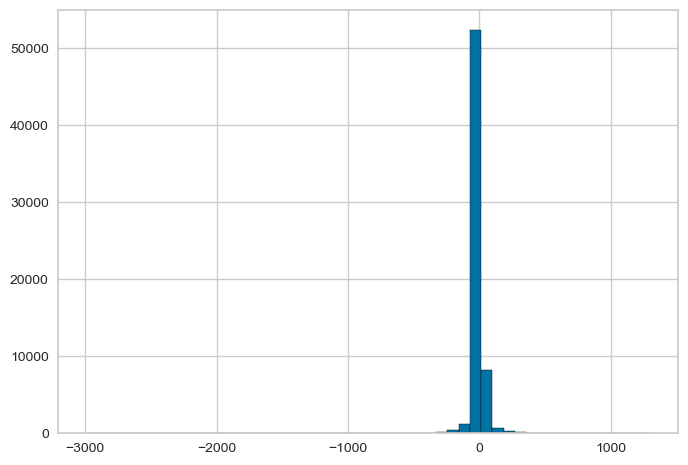

In [14]:
plt.hist(filtered_states['Ratio_Change_Bottom_Tier'], bins=50, edgecolor='black') 

#### Ratio_Change_Top_Tier

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        1.0000e+01, 2.1000e+01, 2.7000e+01, 6.0000e+01, 1.0300e+02,
        2.7800e+02, 9.0700e+02, 4.9538e+04, 1.1777e+04, 6.7500e+02,
        2.1500e+02, 1.1200e+02, 4.8000e+01, 3.0000e+01, 1.1000e+01,
        1.1000e+01, 5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-2384.25611411, -2311.78861816, -2239.32112221, -2166.85362626,
        -2094.3861303 , -2021.91863435, -1949.4511384 , -1876.98364244,
        -1804.51614649, -1732.04865054, -1659.58115458, -1587.11365863,
        -1514.64616268, -1442.17866672, -1369.71117077, -1297.24367482,
        -1224.77617887, -1152.

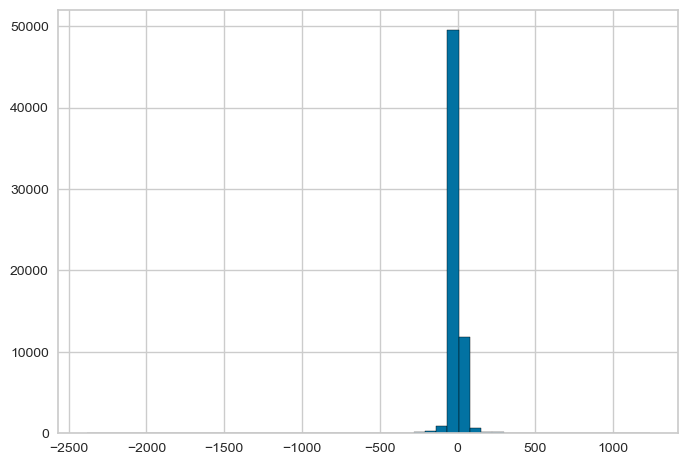

In [15]:
plt.hist(filtered_states['Ratio_Change_Top_Tier'], bins=50, edgecolor='black') 

#### Ratio_Change_Purchase_Price_Tier

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 5.0000e+00, 6.0000e+00, 5.0000e+00,
        1.7000e+01, 1.4000e+01, 3.0000e+01, 4.5000e+01, 8.7000e+01,
        1.7100e+02, 3.0000e+02, 6.3900e+02, 2.8710e+03, 5.4897e+04,
        3.3770e+03, 7.2000e+02, 2.8300e+02, 1.4800e+02, 7.9000e+01,
        4.4000e+01, 3.4000e+01, 1.8000e+01, 1.7000e+01, 9.0000e+00,
        5.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1257.25806452, -1205.96774194, -1154.67741935, -1103.38709677,
        -1052.09677419, -1000.80645161,  -949.51612903,  -898.22580645,
         -846.93548387,  -795.64516129,  -744.35483871,  -693.06451613,
         -641.77419355,  -590.48387097,  -539.19354839,  -487.90322581,
         -436.61290323,  -385.

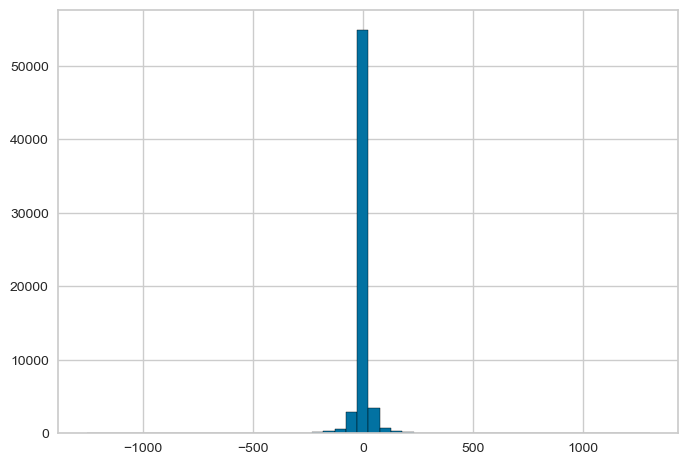

In [16]:
plt.hist(filtered_states['Ratio_Change_Purchase_Price_Tier'], bins=50, edgecolor='black') 

### Standardizing Temperature Anomaly 

In [17]:
# Create a StandardScaler object
scaler = StandardScaler()

# Column Names we want to scale
columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Value', 'Ratio_Change_Purchase_Price_Tier', 'Ratio_Change_Top_Tier', 'Ratio_Change_Bottom_Tier']

# Fit the scaler to the specified columns
scaler.fit(filtered_states[columns_to_scale])

#Transform Data
filtered_states[columns_to_scale] = scaler.transform(filtered_states[columns_to_scale])

# Display the first few rows of the DataFrame to check the results
filtered_states.head()

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),...,AWATER,INTPTLAT,INTPTLON,geometry,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier
478578,569972,2018-09-30,2018,9,Marion County,OH,-0.711078,-0.540096,0.828247,1.189514,...,908577.0,40.588034,-83.168803,"POLYGON ((-83.18826 40.70214, -83.18516 40.702...",22.793916,20.128374,22.034580,0.056646,0.076552,0.081403
480852,275720,2011-04-30,2011,4,Campbell County,WY,1.115258,0.298281,-0.882419,-0.772158,...,11010427.0,44.191999,-105.517014,"POLYGON ((-106.02524 44.97957, -106.02507 44.9...",-6.611577,-3.034208,-21.727486,0.078554,0.048582,0.394661
71739,368495,2013-10-31,2013,10,Manatee County,FL,0.021582,0.291041,1.220763,0.238400,...,573084393.0,27.475556,-82.393144,"POLYGON ((-82.52475 27.64542, -82.51851 27.645...",3.260482,4.243217,7.087576,0.010078,0.034590,0.062221
17392,236122,2010-03-31,2010,3,Contra Costa County,CA,1.166594,1.611898,-0.132538,-0.296601,...,225364427.0,37.919479,-121.951543,"POLYGON ((-121.69732 37.78244, -121.69748 37.7...",3.326220,23.539812,13.719807,0.126259,1.362469,0.756329
420877,141191,2006-09-30,2006,9,Dallas County,IA,-0.029804,0.275187,0.295128,-1.455770,...,8569306.0,41.685321,-94.040706,"POLYGON ((-94.01276 41.50319, -94.01375 41.503...",-17.669550,-3.425641,-9.207630,0.070712,0.012428,0.049024


#### Dropping unnecessary columns 

In [18]:
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
filtered_states[columns_to_float] = filtered_states[columns_to_float].astype(float)

# Get column names with object data types
object_columns = filtered_states.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
filtered_states = filtered_states.drop(object_columns, axis=1)
filtered_states = filtered_states.drop(columns='geometry', axis=1)
filtered_states.drop(columns='Unnamed: 0', inplace=True)

### Classifying the Ratio Changes as Low, Medium, High for Ratio_Change_Bottom_Tier and Ratio_Change_Top_Tier

In [19]:
filtered_states['Ratio_Change_Bottom_Tier'].describe()

count    6.385000e+04
mean    -2.976824e-18
std      1.000008e+00
min     -5.083118e+01
25%     -1.128043e-01
50%     -1.164393e-02
75%      1.091999e-01
max      2.213523e+01
Name: Ratio_Change_Bottom_Tier, dtype: float64

In [20]:
# Calculate quartiles
quartiles = pd.qcut(filtered_states['Ratio_Change_Bottom_Tier'], q=3, labels=['low', 'medium', 'high'])

# Map quartile labels to numeric values
class_mapping = {'low': 0, 'medium': 1, 'high': 2}
filtered_states['Bottom_Tier_Class'] = quartiles.map(class_mapping)

# Display the DataFrame to check the results
filtered_states.head()

,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,...,AWATER,INTPTLAT,INTPTLON,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier,Bottom_Tier_Class
478578,2018,9,-0.711078,-0.540096,0.828247,1.189514,64.4,1.22,4.37,15,...,908577.0,40.588034,-83.168803,22.793916,20.128374,22.034580,0.056646,0.076552,0.081403,2
480852,2011,4,1.115258,0.298281,-0.882419,-0.772158,41.8,0.94,4.52,15,...,11010427.0,44.191999,-105.517014,-6.611577,-3.034208,-21.727486,0.078554,0.048582,0.394661,2
71739,2013,10,0.021582,0.291041,1.220763,0.238400,74.3,1.40,4.77,30,...,573084393.0,27.475556,-82.393144,3.260482,4.243217,7.087576,0.010078,0.034590,0.062221,1
17392,2010,3,1.166594,1.611898,-0.132538,-0.296601,53.0,0.59,4.66,15,...,225364427.0,37.919479,-121.951543,3.326220,23.539812,13.719807,0.126259,1.362469,0.756329,2
420877,2006,9,-0.029804,0.275187,0.295128,-1.455770,64.2,0.48,6.70,30,...,8569306.0,41.685321,-94.040706,-17.669550,-3.425641,-9.207630,0.070712,0.012428,0.049024,2


(array([21284.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21283.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21283.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

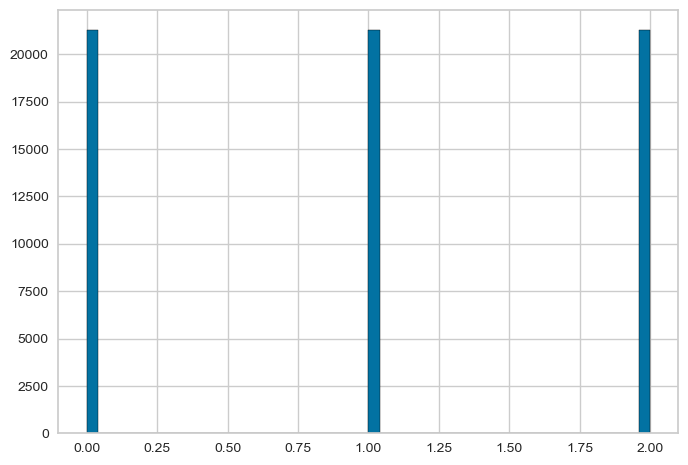

In [21]:
plt.hist(filtered_states['Bottom_Tier_Class'], bins=50, edgecolor='black') 

In [22]:
# Calculate quartiles
quartiles = pd.qcut(filtered_states['Ratio_Change_Top_Tier'], q=3, labels=['low', 'medium', 'high'])

# Map quartile labels to numeric values
class_mapping = {'low': 0, 'medium': 1, 'high': 2}
filtered_states['Top_Tier_Class'] = quartiles.map(class_mapping)

# Display the DataFrame to check the results
filtered_states.head()

,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,...,INTPTLAT,INTPTLON,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier,Bottom_Tier_Class,Top_Tier_Class
478578,2018,9,-0.711078,-0.540096,0.828247,1.189514,64.4,1.22,4.37,15,...,40.588034,-83.168803,22.793916,20.128374,22.034580,0.056646,0.076552,0.081403,2,2
480852,2011,4,1.115258,0.298281,-0.882419,-0.772158,41.8,0.94,4.52,15,...,44.191999,-105.517014,-6.611577,-3.034208,-21.727486,0.078554,0.048582,0.394661,2,1
71739,2013,10,0.021582,0.291041,1.220763,0.238400,74.3,1.40,4.77,30,...,27.475556,-82.393144,3.260482,4.243217,7.087576,0.010078,0.034590,0.062221,1,1
17392,2010,3,1.166594,1.611898,-0.132538,-0.296601,53.0,0.59,4.66,15,...,37.919479,-121.951543,3.326220,23.539812,13.719807,0.126259,1.362469,0.756329,2,2
420877,2006,9,-0.029804,0.275187,0.295128,-1.455770,64.2,0.48,6.70,30,...,41.685321,-94.040706,-17.669550,-3.425641,-9.207630,0.070712,0.012428,0.049024,2,1


(array([21284.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21283.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21283.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

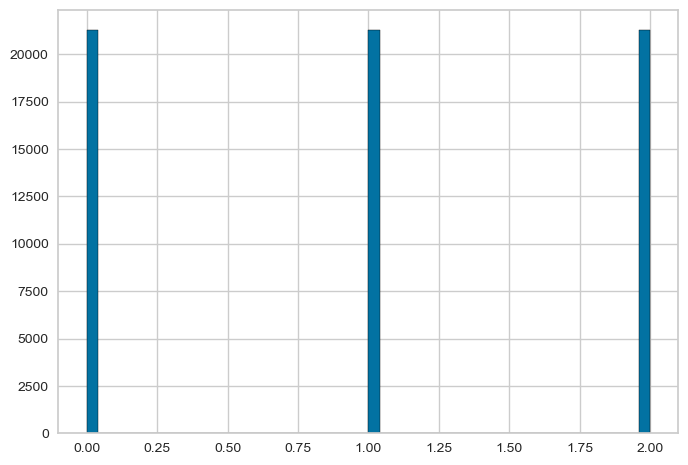

In [23]:
plt.hist(filtered_states['Top_Tier_Class'], bins=50, edgecolor='black') 

In [24]:
# Calculate quartiles
quartiles = pd.qcut(filtered_states['Ratio_Change_Purchase_Price_Tier'], q=3, labels=['low', 'medium', 'high'])

# Map quartile labels to numeric values
class_mapping = {'low': 0, 'medium': 1, 'high': 2}
filtered_states['Purchase_Price_Class'] = quartiles.map(class_mapping)

# Display the DataFrame to check the results
filtered_states.head()



,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,...,INTPTLON,Pct_Change_Bottom_Tier,Pct_Change_Top_Tier,Pct_Change,Ratio_Change_Bottom_Tier,Ratio_Change_Top_Tier,Ratio_Change_Purchase_Price_Tier,Bottom_Tier_Class,Top_Tier_Class,Purchase_Price_Class
478578,2018,9,-0.711078,-0.540096,0.828247,1.189514,64.4,1.22,4.37,15,...,-83.168803,22.793916,20.128374,22.034580,0.056646,0.076552,0.081403,2,2,2
480852,2011,4,1.115258,0.298281,-0.882419,-0.772158,41.8,0.94,4.52,15,...,-105.517014,-6.611577,-3.034208,-21.727486,0.078554,0.048582,0.394661,2,1,2
71739,2013,10,0.021582,0.291041,1.220763,0.238400,74.3,1.40,4.77,30,...,-82.393144,3.260482,4.243217,7.087576,0.010078,0.034590,0.062221,1,1,1
17392,2010,3,1.166594,1.611898,-0.132538,-0.296601,53.0,0.59,4.66,15,...,-121.951543,3.326220,23.539812,13.719807,0.126259,1.362469,0.756329,2,2,2
420877,2006,9,-0.029804,0.275187,0.295128,-1.455770,64.2,0.48,6.70,30,...,-94.040706,-17.669550,-3.425641,-9.207630,0.070712,0.012428,0.049024,2,1,1


(array([21284.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21283.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21283.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
        1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
        1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ]),
 <BarContainer object of 50 artists>)

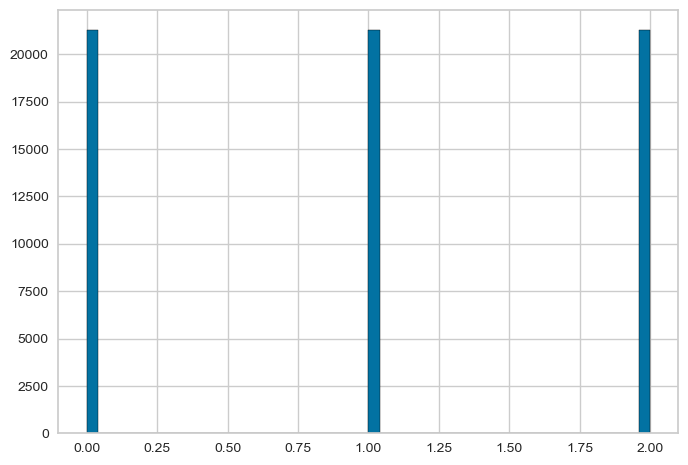

In [25]:
plt.hist(filtered_states['Purchase_Price_Class'], bins=50, edgecolor='black') 

In [26]:

pd.concat({"Number missing values":filtered_states.isnull().sum()
            , "Percentage of missing values":filtered_states.isnull().sum()*100/filtered_states.shape[0]}
            , axis=1)

,Number missing values,Percentage of missing values
Year,0,0.0
Month,0,0.0
Bottom-Tier Average Home Value Estimate,0,0.0
Top-Tier Average Home Value Estimate,0,0.0
Value,0,0.0
Anomaly (1901-2000 base period),0,0.0
1901-2000 Mean,0,0.0
Initial Fees and Charges (%),0,0.0
Effective Rate (%),0,0.0
Term to Maturity,0,0.0


## Train/Test Splitting Data

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_19827/3227028722.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = filtered_states.corr()


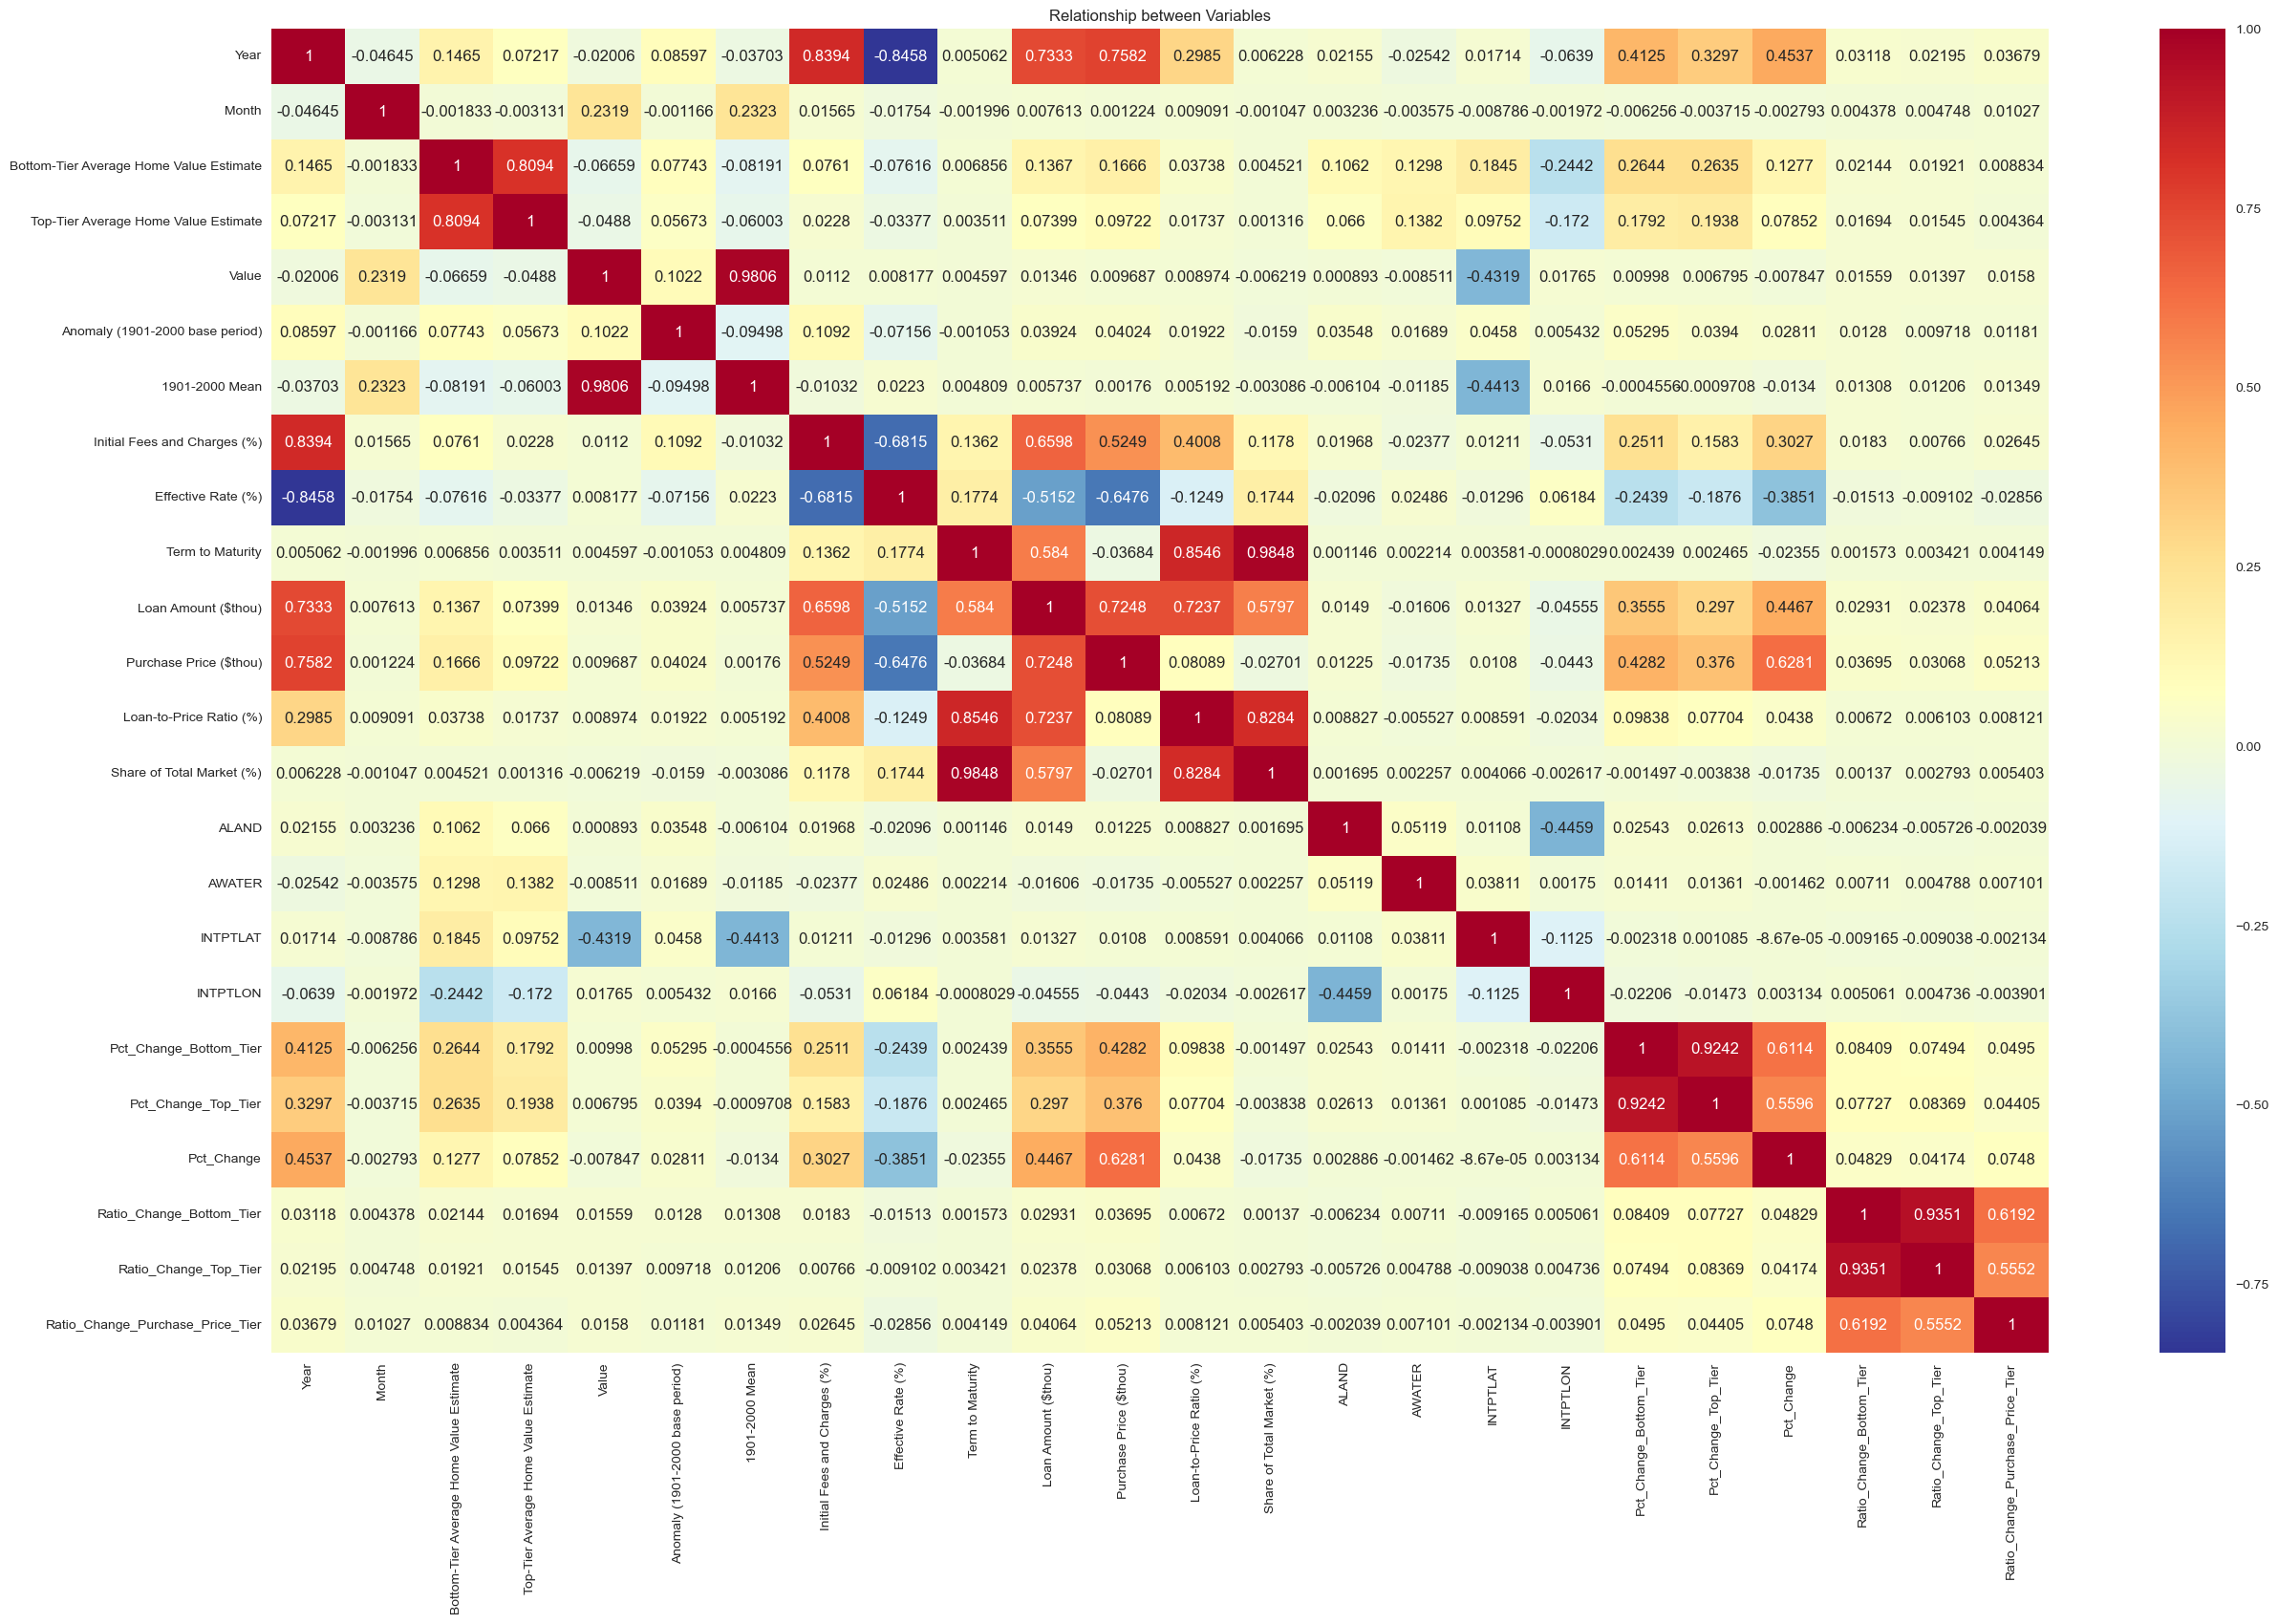

In [27]:
corr_matrix = filtered_states.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [36]:
#splitting the data 
seed = 7

test = filtered_states[filtered_states['Year'] == 2019]
train = filtered_states[filtered_states['Year'] != 2019]

X_train= train[train.columns.difference(['Bottom_Tier_Class','Top_Tier_Class', 'Purchase_Price_Class', 'Pct_Change_Top_Tier'])]
X_test = test[test.columns.difference(['Bottom_Tier_Class','Top_Tier_Class', 'Purchase_Price_Class', 'Pct_Change_Top_Tier'])]

X_train_selected = X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
X_test_selected = X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

y_train = train['Bottom_Tier_Class']
y_test = test['Bottom_Tier_Class']

## Exploring Models for Top Tier Average Home Values

1. Naive Bayes
2. Logistic Regression

### 1. Naive Bayes

[[ 59  56 304]
 [  0 213   9]
 [  2  74 634]]
              precision    recall  f1-score   support

         Low       0.97      0.14      0.25       419
      Medium       0.62      0.96      0.75       222
        High       0.67      0.89      0.77       710

    accuracy                           0.67      1351
   macro avg       0.75      0.66      0.59      1351
weighted avg       0.75      0.67      0.60      1351



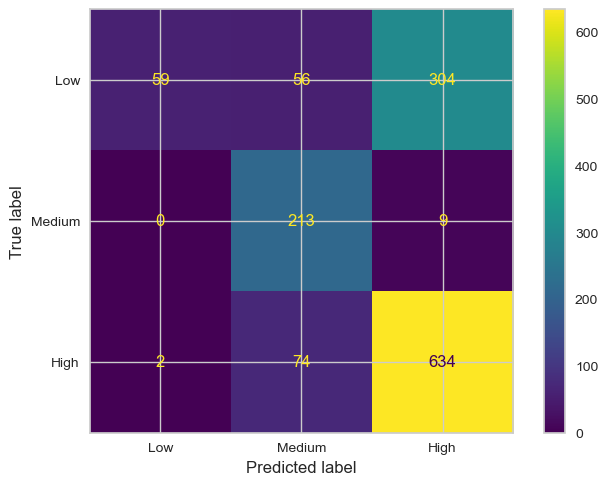

In [38]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train_selected, y_train)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train_selected)
y_test_pred_NB = modelNB.predict(X_test_selected)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Labels
labels = ['Low', 'Medium', 'High']
#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### 2. Logistic Regression

[[391  27   1]
 [  1 213   8]
 [  0  20 690]]
              precision    recall  f1-score   support

         Low       1.00      0.93      0.96       419
      Medium       0.82      0.96      0.88       222
        High       0.99      0.97      0.98       710

    accuracy                           0.96      1351
   macro avg       0.93      0.95      0.94      1351
weighted avg       0.96      0.96      0.96      1351



/Users/yokokentilitisca/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


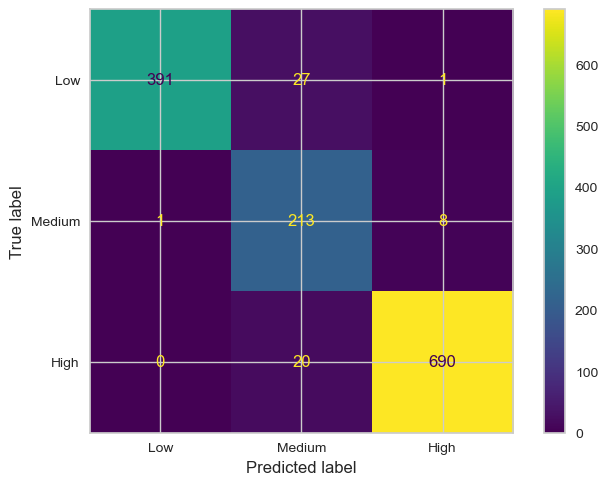

In [40]:
# your code here
model_lr = LogisticRegression(max_iter=10000)

#Fitting the model to SMOTE
model_lr.fit(X_train_selected, y_train)

#Getting predictions
y_train_pred_lr = model_lr.predict(X_train_selected)
y_test_pred_lr = model_lr.predict(X_test_selected)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_lr))

#Print the classification report
print(classification_report(y_test, y_test_pred_lr, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Confusion Matrix:
[[271   0   0]
 [  0 217   0]
 [  0   0 572]]
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       271
      Medium       1.00      1.00      1.00       217
        High       1.00      1.00      1.00       572

    accuracy                           1.00      1060
   macro avg       1.00      1.00      1.00      1060
weighted avg       1.00      1.00      1.00      1060



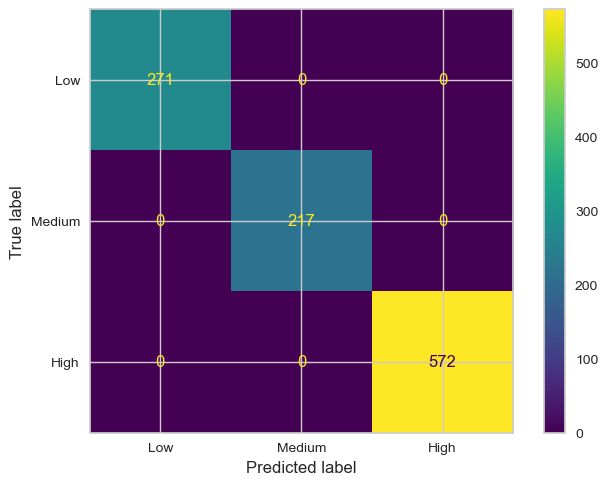

In [42]:
#your code here
model_abc = AdaBoostClassifier()

#Fit the model
model_abc.fit(X_train_selected, y_train)

#Evaluate the model, Predictions
y_pred_train_abc = model_abc.predict(X_train_selected)
y_pred_test_abc = model_abc.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_abc ))

#Print the classification report
print(classification_report(y_test, y_pred_test_abc , target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_abc )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()